# Food Prices time-series dataset released by WFP

Link to Food Prices data released by WFP: https://dataviz.vam.wfp.org/economic_explorer/prices

In [1]:
from IPython.display import HTML as html

html('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
from plotly_dataframe import plot
from plot_map import draw_admin
import pandas as pd
import numpy as np
import ntpath
import glob
# Set a value to column width in order to not view dataframe too bulky.
pd.options.display.max_colwidth = 30

In [2]:
# Define the path where the results arising from this analysis will be saved.
path_to_save_data = "./time-series/"

# Month granularity data - YEM, NGA, SYR, BFA

The market price data of four countries have been downloaded: *Yemen* (YEM), *Nigeria* (NGA), *Syria* (SYR) and *Burkina Faso* (BFA). These countries have been chosen according to the data of the FCS & rCSI indicators.

In [3]:
# Read the data released by WFP regarding the market price indicator.
path = "./wfp_data/"
all_files = glob.glob(path + "*.csv")

dfs = []

# Concatenate the data of the countries in an unique dataframe.
for filename in all_files:
    df = pd.read_csv(filename)
    df["Country"] = ntpath.basename(filename).split(".")[0]
    dfs.append(df)

df = pd.concat(dfs, axis = 0, ignore_index = True)
print("The data released by wfp:")
df.head()

The data released by wfp:


,Country,Admin 1,Market,Commodity,Price Type,Year,Month,Price,Unit,Currency,Data Source
0,Burkina Faso,Boucle Du Mouhoun,Tougan,Maize,Retail,2003,1,156.2500,KG,XOF,SIM/SONAGESS
1,Burkina Faso,Boucle Du Mouhoun,Tougan,Maize,Retail,2003,2,156.2500,KG,XOF,SIM/SONAGESS
2,Burkina Faso,Boucle Du Mouhoun,Tougan,Maize,Retail,2003,3,153.5156,KG,XOF,SIM/SONAGESS
3,Burkina Faso,Boucle Du Mouhoun,Tougan,Maize,Retail,2003,4,156.2500,KG,XOF,SIM/SONAGESS
4,Burkina Faso,Boucle Du Mouhoun,Tougan,Maize,Retail,2003,5,156.2500,KG,XOF,SIM/SONAGESS


As you note, the data have a month granularity. I convert the temporal information to an appropriate pandas datetime object.

In [4]:
# Select only the data beyond a selected year.
year = 2015

In [5]:
print("Select only the data beyond the year %d." % year)
df = df.loc[df.Year >= year]
# Create an appropriate pandas datetime object taking last day of the month as reference for the month itself.
data = pd.to_datetime(df["Year"].astype(int).astype(str) + df["Month"].astype(int).astype(str), format = "%Y%m") + pd.tseries.offsets.MonthEnd()
df.insert(1, "Datetime", data)
df.drop(["Year", "Month"], axis = 1, inplace = True) 
df.sort_values("Datetime", ascending = True, inplace = True) 
df.reset_index(drop = True, inplace = True)
# Rename the column of the adminstrata.
df.rename(columns = {"Admin 1": "AdminStrata"}, inplace = True)
df.head()

Select only the data beyond the year 2015.


,Country,Datetime,AdminStrata,Market,Commodity,Price Type,Price,Unit,Currency,Data Source
0,Burkina Faso,2015-01-31,Boucle Du Mouhoun,Tougan,Maize,Retail,160.0,KG,XOF,SIM/SONAGESS
1,Syria,2015-01-31,Idleb,Bennsh,Livestock (sheep two-year-...,Retail,NaN,Unit,SYP,NaN
2,Nigeria,2015-01-31,Borno,Maiduguri,Maize (yellow),Wholesale,6375.0,100 KG,NGN,FEWS NET; Nigeria
3,Syria,2015-01-31,Lattakia,Lattakia,Rice,Retail,220.0,KG,SYP,Field Monitors/Tartous Sub...
4,Syria,2015-01-31,Lattakia,Lattakia,Wheat flour,Retail,110.0,KG,SYP,Field Monitors/Tartous Sub...


In [6]:
# Remove multiple spaces that are present for some string values: e.g. the value "Livestock (sheep two-year-old male) " of the commodity column wil be replaced with "Livestock (sheep two-year-old male)".
df = df.applymap(lambda x: " ".join(x.split()) if type(x) is str else x)

### Brief items description

In [7]:
print("Check if the dataframe contains NaN values:")
df.isnull().sum()

Check if the dataframe contains NaN values:


Country            0
Datetime           0
AdminStrata        0
Market             0
Commodity          0
Price Type         0
Price          13808
Unit               0
Currency           0
Data Source    13808
dtype: int64

Some countries contain some nan values regarding the price of the commodities. In the next cells, I operate an interpolation to fill some of these nan values (set a limit for my interpolation and not all the nan values will be interpolated).

### Country item

In [8]:
print("The countries in the dataset are:", ", ".join(df.Country.unique()))

The countries in the dataset are: Burkina Faso, Syria, Nigeria, Yemen


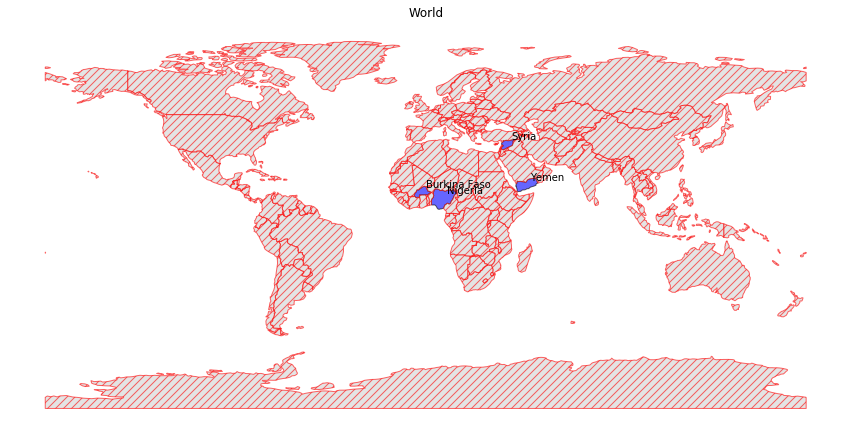

In [9]:
draw_admin("World", df.Country.unique(), figsize = (15, 9), annotation = True, annotation_selected = True)

### AdminStrata item

In [10]:
# Rename the name of some AdminStrata of Syria according to the fcs and rcsi names of the AdminStrata.
df.replace(["As_Suweida", "Dara", "Damascus", "City_Damascus", "Hassakeh", "Raqqa", "Dayr_Az_Zor", "Al_Qunaytirah"], 
           ["As-Sweida", "Dar'a", "Rural Damascus", "Damascus", "Al-Hasakeh", "Ar-Raqqa", "Deir-ez-Zor", "Quneitra"], inplace = True)

In [11]:
# Rename the name of some AdminStrata of Burkina Faso according to the fcs and rcsi names of the AdminStrata.
df.replace(["Boucle Du Mouhoun", "Sud-ouest", "Plateau Central", "Centre-est", "Centre-ouest", "Centre-nord", "Centre-sud", "Hauts-bassins"], 
           ["Boucle-Du-Mouhoun", "Sud-Ouest", "Plateau-Central", "Centre-Est", "Centre-Ouest", "Centre-Nord", "Centre-Sud", "Hauts-Bassins"], inplace = True)

In [12]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen**: the administrative division of Yemen is divided into two main divisions (governorates and districts). There are 22 governorates, including the capital Sana'a (Amanat Al Asimah) and Socotra Archipelago. The Food Prices dataframe has the values of 21 governorates (Socotra not included).

In [13]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(21,)


array(['Amran', 'Hadramaut', 'Hajjah', 'Al Hudaydah', "Sa'ada", 'Aden',
       'Taizz', 'Amanat Al Asimah', 'Dhamar', "Al Dhale'e", 'Al Maharah',
       'Lahj', 'Al Bayda', 'Raymah', 'Al Jawf', 'Ibb', "Sana'a",
       'Shabwah', 'Marib', 'Al Mahwit', 'Abyan'], dtype=object)

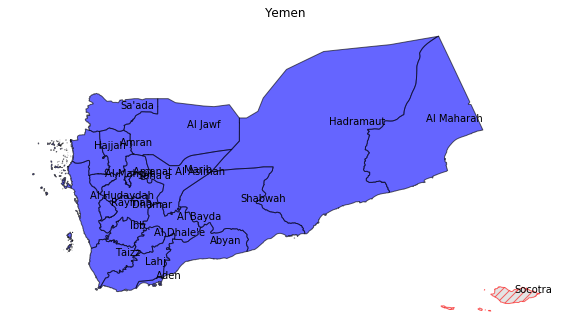

In [14]:
draw_admin("Yemen", AdminStratas["Yemen"], figsize = (10, 7), annotation = True)

- **Nigeria**: Nigeria is divided into 36 states. It also includes *The Federal Capital Territory* that is not a state and it is under the direct control of the federal government. The AdminStrata items of the Food Price dataframe cover 14 states.

In [15]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(14,)


array(['Borno', 'Jigawa', 'Kaduna', 'Adamawa', 'Oyo', 'Lagos', 'Gombe',
       'Yobe', 'Sokoto', 'Zamfara', 'Abia', 'Kebbi', 'Kano', 'Katsina'],
      dtype=object)

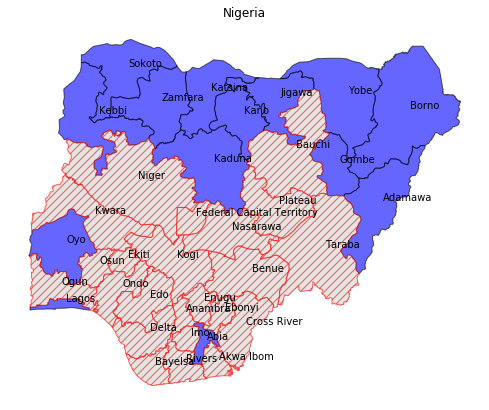

In [16]:
draw_admin("Nigeria", AdminStratas["Nigeria"], figsize = (10, 7), annotation = True)

- **Syria**: the governatores of the Syria country are 14. The Food Price dataframe has the values of all 14 governatores.

In [17]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(14,)


array(['Idleb', 'Lattakia', 'Ar-Raqqa', 'Homs', 'Al-Hasakeh', 'Tartous',
       'Aleppo', 'As-Sweida', 'Damascus', 'Quneitra', 'Deir-ez-Zor',
       "Dar'a", 'Hama', 'Rural Damascus'], dtype=object)

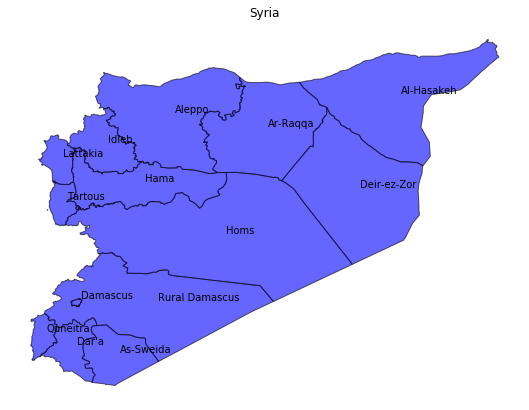

In [18]:
draw_admin("Syria", AdminStratas["Syria"], figsize = (10, 7), annotation = True)

- **Burkina Faso**: Burkina Faso is divided into 13 administrative regions. The Food Price dataframe has the values of all 13 regions.

In [19]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Est', 'Centre-Ouest', 'Plateau-Central',
       'Nord', 'Hauts-Bassins', 'Centre', 'Cascades', 'Centre-Est',
       'Centre-Nord', 'Sahel', 'Sud-Ouest', 'Centre-Sud'], dtype=object)

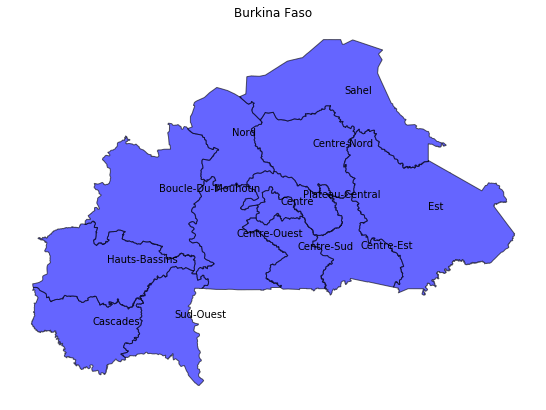

In [20]:
draw_admin("Burkina Faso", AdminStratas["Burkina Faso"], figsize = (10, 7), annotation = True)

## Other items

In [16]:
print("The various type of commodities:")
df.Commodity.unique()

The various type of commodities:


array(['Maize', 'Livestock (sheep two-year-old male)', 'Maize (yellow)',
       'Rice', 'Wheat flour', 'Sorghum (white)', 'Beans (white)',
       'Potatoes', 'Sugar', 'Groundnuts (shelled)', 'Lentils', 'Pasta',
       'Tomatoes', 'Yam', 'Oil', 'Chickpeas', 'Bulgur', 'Millet',
       'Wage (non-qualified labour)', 'Bread (bakery)', 'Bread (shop)',
       'Rice (local)', 'Fuel (gas)', 'Tea', 'Fuel (diesel)',
       'Gari (white)', 'Gari (yellow)', 'Sorghum (brown)',
       'Cowpeas (brown)', 'Cowpeas (white)', 'Fuel (petrol-gasoline)',
       'Tomatoes (paste)', 'Maize (white)', 'Rice (imported)',
       'Oil (palm)', 'Bread', 'Rice (milled local)', 'Sorghum', 'Onions',
       'Sorghum (local)', 'Salt', 'Beans (kidney red)',
       'Peas (yellow split)', 'Wheat', 'Oil (vegetable)', 'Eggs',
       'Beans (niebe)', 'Yam (Abuja)', 'Meat (mutton)', 'Meat (chicken)',
       'Fish (sardine canned)', 'Fish (tuna canned)',
       'Meat (beef minced)', 'Dates', 'Yogurt', 'Labaneh', 'Yeast',
     

Each country doesn't have a time-series for all this commodities but only some of them.

In [17]:
print("The unit of measure of the commodoties:")
df.Unit.unique()

The unit of measure of the commodoties:


array(['KG', 'Unit', '100 KG', 'L', 'Day', '1.3 KG', '10 KG', '650 G',
       '50 KG', '100 L', '125 G', '30 pcs', '185 G', 'Packet', '18 KG',
       'Head', 'USD/LCU', 'Cubic meter', 'MT'], dtype=object)

In [18]:
print("Check if some commodities are measured using different unit type:")
commodities_units = dict()

def unit_check(group):
    if len(group.Unit.unique()) > 1:
        commodities_units[group.Commodity.unique()[0]] = list(group.Unit.unique())

df.groupby(["Commodity"]).apply(unit_check)
print(commodities_units)

Check if some commodities are measured using different unit type:
{'Bulgur': ['KG', 'MT'], 'Cowpeas (brown)': ['100 KG', 'KG'], 'Cowpeas (white)': ['100 KG', 'KG'], 'Eggs': ['Unit', '30 pcs'], 'Fuel (gas)': ['10 KG', '18 KG'], 'Gari (white)': ['100 KG', 'KG'], 'Gari (yellow)': ['100 KG', 'KG'], 'Groundnuts (shelled)': ['100 KG', 'KG'], 'Livestock (sheep two-year-old male)': ['Unit', 'Head'], 'Maize (white)': ['100 KG', 'KG'], 'Maize (yellow)': ['100 KG', 'KG', '50 KG'], 'Millet': ['100 KG', 'KG'], 'Oil (palm)': ['L', '100 L', '100 KG'], 'Oil (vegetable)': ['L', 'KG'], 'Rice': ['KG', 'MT'], 'Rice (imported)': ['50 KG', 'KG', '100 KG'], 'Rice (local)': ['100 KG', 'KG'], 'Rice (milled local)': ['50 KG', '100 KG'], 'Sorghum (brown)': ['100 KG', 'KG'], 'Sorghum (white)': ['100 KG', 'KG'], 'Wheat': ['KG', 'MT'], 'Yam': ['100 KG', 'KG'], 'Yam (Abuja)': ['KG', '100 KG']}


Convert all the commodities with double unit to have a single unit and the commodities with single unit to have a small unit (as KG).

In [19]:
# Convert all the commodities with double unit to have a single unit and the commodities with single unit to have a small unit (as KG).
def adjust_unit(group):
    def adjusting(row):
        a = row.Unit
        b = row.Price
        c = row.Commodity
        # Select the common unit of measure.
        if c == "Oil (palm)":
            if a == "100 KG":
                a = "L"
                b = (row.Price/100)*0.92  
            elif a == "100 L":
                a = "L"
                b = row.Price/100
        elif a == "KG" and c == "Oil (vegetable)":
            a = "L"
            b = row.Price*0.92  
        elif row.Unit == "100 KG":
            a = "KG"
            b = row.Price/100
        elif row.Unit == "50 KG":
            a = "KG"
            b = row.Price/50
        elif row.Unit == "MT":
            a = "KG"
            b = row.Price/1000
        elif row.Unit == "100 L":
            a = "L"
            b = row.Price/100
        elif row.Unit == "30 pcs":
            a = "Unit"
            b = row.Price/30
        elif row.Unit == "18 KG":
            a = "KG"
            b = row.Price/18
        elif row.Unit == "10 KG":
            a = "KG"
            b = row.Price/10
        elif row.Unit == "1.3 KG":
            a = "KG"
            b = row.Price/1.3
        elif row.Unit == "1.3 KG":
            a = "KG"
            b = row.Price/1.3
        elif row.Unit == "650 G":
            a = "KG"
            b = row.Price/0.65
        elif row.Unit == "125 G":
            a = "KG"
            b = row.Price/0.125
        elif row.Unit == "185 G":
            a = "KG"
            b = row.Price/0.185
        elif a == "Head" and c == "Livestock (sheep two-year-old male)":
            a = "Unit"
            b = row.Price
            
        return pd.Series([a, b, c])    
   
    #if len(group.Unit.unique()) > 1:
    group[["Unit", "Price", "Commodity"]] = group.apply(adjusting, axis = 1)

    return group    

In [20]:
print("Convert all the commodities with double unit to have a single unit (and also the commodities with single unit to have small unit):")
df = df.groupby(["Commodity"]).apply(adjust_unit)
df.head()

Convert all the commodities with double unit to have a single unit (and also the commodities with single unit to have small unit):


,Country,Datetime,AdminStrata,Market,Commodity,Price Type,Price,Unit,Currency,Data Source
0,Burkina Faso,2015-01-31,Boucle-Du-Mouhoun,Tougan,Maize,Retail,160.00,KG,XOF,SIM/SONAGESS
1,Syria,2015-01-31,Idleb,Bennsh,Livestock (sheep two-year-...,Retail,NaN,Unit,SYP,NaN
2,Nigeria,2015-01-31,Borno,Maiduguri,Maize (yellow),Wholesale,63.75,KG,NGN,FEWS NET; Nigeria
3,Syria,2015-01-31,Lattakia,Lattakia,Rice,Retail,220.00,KG,SYP,Field Monitors/Tartous Sub...
4,Syria,2015-01-31,Lattakia,Lattakia,Wheat flour,Retail,110.00,KG,SYP,Field Monitors/Tartous Sub...


In [21]:
print("Check if some commodities are still measured using different Unit type:")
commodities_units = dict()

df.groupby(["Commodity"]).apply(unit_check)
print(commodities_units)

Check if some commodities are still measured using different Unit type:
{}


In [22]:
print("Add a suffix to each Commodity corresponding to the value unit:")
def add_unit(row):
    a = row.Commodity
    b = row.Unit
    return pd.Series([a + " (" + b + ")", b])

df[["Commodity", "Unit"]] = df.apply(add_unit, axis = 1)
df.head()

Add a suffix to each Commodity corresponding to the value unit:


,Country,Datetime,AdminStrata,Market,Commodity,Price Type,Price,Unit,Currency,Data Source
0,Burkina Faso,2015-01-31,Boucle-Du-Mouhoun,Tougan,Maize (KG),Retail,160.00,KG,XOF,SIM/SONAGESS
1,Syria,2015-01-31,Idleb,Bennsh,Livestock (sheep two-year-...,Retail,NaN,Unit,SYP,NaN
2,Nigeria,2015-01-31,Borno,Maiduguri,Maize (yellow) (KG),Wholesale,63.75,KG,NGN,FEWS NET; Nigeria
3,Syria,2015-01-31,Lattakia,Lattakia,Rice (KG),Retail,220.00,KG,SYP,Field Monitors/Tartous Sub...
4,Syria,2015-01-31,Lattakia,Lattakia,Wheat flour (KG),Retail,110.00,KG,SYP,Field Monitors/Tartous Sub...


In [23]:
print("The price types:")
df["Price Type"].unique()

The price types:


array(['Retail', 'Wholesale'], dtype=object)

In [24]:
print("Check if some commodities are measured using different price type:")
commodities_types = dict()

def type_check(group):
    if len(group.Unit.unique()) > 1:
        commodities_types[group.Commodity.unique()[0]] = list(group["Price Type"].unique())

df.groupby(["Commodity"]).apply(type_check)
print(commodities_types)

Check if some commodities are measured using different price type:
{}


In [25]:
print("The currencies are:")
df.Currency.unique()

The currencies are:


array(['XOF', 'SYP', 'NGN', 'YER'], dtype=object)

In [26]:
# Check if the currency is changed in the analyzed countries.
print(df[df.Country == "Yemen"].Currency.unique())
print(df[df.Country == "Nigeria"].Currency.unique())
print(df[df.Country == "Syria"].Currency.unique())
print(df[df.Country == "Burkina Faso"].Currency.unique())

['YER']
['NGN']
['SYP']
['XOF']


In [27]:
# Delete the unutilized columns.
df.drop(labels = ["Market", "Price Type", "Unit", "Currency", "Data Source"], axis = 1, inplace = True)
df.head()

,Country,Datetime,AdminStrata,Commodity,Price
0,Burkina Faso,2015-01-31,Boucle-Du-Mouhoun,Maize (KG),160.00
1,Syria,2015-01-31,Idleb,Livestock (sheep two-year-...,NaN
2,Nigeria,2015-01-31,Borno,Maize (yellow) (KG),63.75
3,Syria,2015-01-31,Lattakia,Rice (KG),220.00
4,Syria,2015-01-31,Lattakia,Wheat flour (KG),110.00


In [28]:
# Create appropriate time-series subgroups with an appropriate datetime object sampling to month. 
df = df.groupby(["Country", "AdminStrata", "Commodity"]).apply(lambda group: group.set_index("Datetime").resample("M").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Commodity,Datetime,Price
0,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-01-31,269.7368
1,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-02-28,287.5000
2,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-03-31,298.8889
3,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-04-30,311.1111
4,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-05-31,297.9479


In [29]:
# Take into memory this dataframe to use in the next cells.
dataframe = df.copy()

In [30]:
# Create a dataframe with multindex column in order to have a summary dataframe of the time-series.
df = df.set_index(["Datetime", "Country", "AdminStrata", "Commodity"]).unstack(["Country", "AdminStrata", "Commodity"])
df.columns = df.columns.droplevel(0)
df.columns.rename("AdminStrata", level = 1, inplace = True)
freq = "M"
df.index.freq = freq
df.head()

Country           Burkina Faso                                              \
AdminStrata  Boucle-Du-Mouhoun                                               
Commodity   Beans (niebe) (KG) Maize (KG) Millet (KG) Rice (imported) (KG)   
Datetime                                                                     
2015-01-31            269.7368  149.10925   165.77795                400.0   
2015-02-28            287.5000  127.98385   163.23360                400.0   
2015-03-31            298.8889  130.48385   164.41940                400.0   
2015-04-30            311.1111  132.72400   162.39435                400.0   
2015-05-31            297.9479  139.94445   169.32895                400.0   

Country                                                                      \
AdminStrata                                             Cascades              
Commodity   Sorghum (KG) Sorghum (local) (KG) Beans (niebe) (KG) Maize (KG)   
Datetime                                                                      
2015-01-31     143.22465                122.5                NaN      126.0   
2015-02-28     133.28945                127.5                NaN      106.0   
2015-03-31     137.28945                127.5                NaN      106.0   
2015-04-30     137.28945                132.5                NaN      124.0   
2015-05-31     157.77025                147.5              333.0      137.0   

Country                               ...                    Yemen  \
AdminStrata                           ...                    Taizz   
Commodity   Millet (KG) Sorghum (KG)  ... Peas (yellow split) (KG)   
Datetime                              ...                            
2015-01-31        209.0        151.0  ...                      NaN   
2015-02-28        213.0        160.0  ...                      NaN   
2015-03-31        211.0        167.0  ...                      NaN   
2015-04-30        206.0        182.0  ...                      NaN   
2015-05-31        224.0        186.0  ...                      NaN   

Country                                                              \
AdminStrata                                                           
Commodity   Potatoes (KG) Rice (imported) (KG) Salt (KG) Sugar (KG)   
Datetime                                                              
2015-01-31            NaN                  NaN       NaN        NaN   
2015-02-28            NaN                  NaN       NaN        NaN   
2015-03-31            NaN                  NaN       NaN        NaN   
2015-04-30            NaN                  NaN       NaN        NaN   
2015-05-31            NaN                  NaN       NaN        NaN   

Country                                                      \
AdminStrata                                                   
Commodity   Tomatoes (KG) Wage (non-qualified labour) (Day)   
Datetime                                                      
2015-01-31            NaN                            NaN      
2015-02-28            NaN                            NaN      
2015-03-31            NaN                            NaN      
2015-04-30            NaN                            NaN      
2015-05-31            NaN                            NaN      

Country                                                                
AdminStrata                                                            
Commodity   Wage (qualified labour) (Day) Wheat (KG) Wheat flour (KG)  
Datetime                                                               
2015-01-31                            NaN        NaN              NaN  
2015-02-28                            NaN        NaN              NaN  
2015-03-31                            NaN        NaN              NaN  
2015-04-30                            NaN        NaN              NaN  
2015-05-31                            NaN        NaN              NaN  

[5 rows x 1375 columns]

In [33]:
plot(df, title = "Food Prices - Commodity - Monthly", style = "lines+markers", yaxis = "Price", 
     first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [34]:
# Now save the time-series of each country keeping as indeces the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(path_to_save_data + country + "/" + name + ".csv", index_label = False)

In [35]:
# Save the dataframe.
_ = df.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_market_price-monthly-original"))

## Food group according to the Food Consumption Score survey

Following the survey table of the Food Consumption Score (images below), I set a new attribute value to each commodities corresponding to a macro food group.

In [36]:
# Recovery of the previous dataframe with no multi-columns.
df_food_group = dataframe.copy()
df_food_group.head()

,Country,AdminStrata,Commodity,Datetime,Price
0,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-01-31,269.7368
1,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-02-28,287.5000
2,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-03-31,298.8889
3,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-04-30,311.1111
4,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-05-31,297.9479


Add a new information about the food group according to the fcs survey:

<tr>
    <td> <img src="./images/fcs_1.png" width="400"/> </td>
    <td> <img src="./images/fcs_2.png" width="400"/> </td>
</tr>

In [37]:
# Add the information about the food group according to the fcs survey.
def food_group(row):
    if row.Commodity in ["Sorghum (KG)", "Wheat (KG)", "Wheat flour (KG)", "Rice (imported) (KG)", "Potatoes (KG)", 
                         "Millet (KG)", "Beans (niebe) (KG)", "Maize (KG)", "Sorghum (local) (KG)", "Bread (Unit)", 
                         "Pasta (spaghetti) (KG)", "Gari (white) (KG)", "Gari (yellow) (KG)", "Maize (white) (KG)", 
                         "Maize (yellow) (KG)", "Rice (local) (KG)", "Sorghum (brown) (KG)", "Sorghum (white) (KG)", 
                         "Yam (KG)", "Yam (Abuja) (KG)", "Bread (bakery) (KG)", "Bread (shop) (KG)", "Bulgur (KG)", 
                         "Pasta (KG)", "Rice (KG)", "Yeast (KG)", "Rice (milled local) (KG)"]:
        return "Main staples"
    elif row.Commodity in ["Beans (kidney red) (KG)", "Beans (white) (KG)", "Peas (yellow split) (KG)", "Lentils (KG)", 
                           "Cowpeas (brown) (KG)", "Cowpeas (white) (KG)", "Groundnuts (shelled) (KG)", "Chickpeas (KG)", 
                           "Peanut (KG)"]:
        return "Pulses"
    elif row.Commodity in ["Tomatoes (KG)", "Onions (KG)", "Carrots (KG)", "Eggplants (KG)", "Parsley (Packet)", "Pumpkin (KG)", 
                           "Spinach (Packet)", "Tomatoes (paste) (KG)"]:
        return "Vegetables"
    elif row.Commodity in ["Apples (KG)", "Bananas (KG)", "Dates (KG)"]:
        return "Fruit"
    elif row.Commodity in ["Meat (mutton) (KG)", "Meat (chicken) (KG)", "Eggs (Unit)", "Livestock (sheep two-year-old male) (Unit)", 
                           "Fish (sardine canned) (KG)", "Fish (tuna canned) (KG)", "Meat (beef minced) (KG)", 
                           "Meat (chicken plucked) (KG)"]:
        return "Meet, fish and eggs"
    elif row.Commodity in ["Cheese (KG)", "Labaneh (KG)", "Milk (cow fresh) (L)", "Yogurt (KG)"]:
        return "Milk"
    elif row.Commodity in ["Oil (vegetable) (L)", "Oil (palm) (L)", "Oil (L)"]:
        return "Oil"
    elif row.Commodity in ["Sugar (KG)"]:
        return "Sugar"
    elif row.Commodity in ["Salt (KG)", "Salt (iodised) (KG)", "Tea (KG)"]:
        return "Condiments"
    elif row.Commodity in ["Fuel (diesel) (L)", "Fuel (gas) (KG)", "Fuel (petrol-gasoline) (L)"]:
        return "Fuel"
    elif row.Commodity in ["Wage (non-qualified labour) (Day)", "Wage (qualified labour) (Day)"]:
        return "Wage"
    elif row.Commodity in ["Exchange rate (unofficial) (USD/LCU)"]:
        return "Exchange rate"
    elif row.Commodity in ["Milling cost (wheat) (KG)"]:
        return "Milling cost"
    elif row.Commodity in ["Water (drinking) (Cubic meter)"]:
        return "Water"
    
df_food_group["Food Group"] = df_food_group.apply(food_group, axis = 1)
df_food_group.head()

,Country,AdminStrata,Commodity,Datetime,Price,Food Group
0,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-01-31,269.7368,Main staples
1,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-02-28,287.5000,Main staples
2,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-03-31,298.8889,Main staples
3,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-04-30,311.1111,Main staples
4,Burkina Faso,Boucle-Du-Mouhoun,Beans (niebe) (KG),2015-05-31,297.9479,Main staples


In [38]:
# Check if some commodities don't have a food group item.
df_food_group["Food Group"].isna().sum()

0

In [39]:
# Create a dataframe with multindex column in order to have a summary dataframe of the time-series.
df_food_group = df_food_group.set_index(["Datetime", "Country", "AdminStrata", "Food Group", "Commodity"]).unstack(["Country", "AdminStrata", "Food Group", "Commodity"]).sort_index(axis = 1,level = 0)
df_food_group.columns = df_food_group.columns.droplevel(0)
df_food_group.columns.rename("AdminStrata", level = 1, inplace = True)
freq = "M"
df_food_group.index.freq = freq
df_food_group.head()

Country           Burkina Faso                                              \
AdminStrata  Boucle-Du-Mouhoun                                               
Food Group        Main staples                                               
Commodity   Beans (niebe) (KG) Maize (KG) Millet (KG) Rice (imported) (KG)   
Datetime                                                                     
2015-01-31            269.7368  149.10925   165.77795                400.0   
2015-02-28            287.5000  127.98385   163.23360                400.0   
2015-03-31            298.8889  130.48385   164.41940                400.0   
2015-04-30            311.1111  132.72400   162.39435                400.0   
2015-05-31            297.9479  139.94445   169.32895                400.0   

Country                                                                      \
AdminStrata                                             Cascades              
Food Group                                          Main staples              
Commodity   Sorghum (KG) Sorghum (local) (KG) Beans (niebe) (KG) Maize (KG)   
Datetime                                                                      
2015-01-31     143.22465                122.5                NaN      126.0   
2015-02-28     133.28945                127.5                NaN      106.0   
2015-03-31     137.28945                127.5                NaN      106.0   
2015-04-30     137.28945                132.5                NaN      124.0   
2015-05-31     157.77025                147.5              333.0      137.0   

Country                               ...               Yemen  \
AdminStrata                           ...               Taizz   
Food Group                            ...                 Oil   
Commodity   Millet (KG) Sorghum (KG)  ... Oil (vegetable) (L)   
Datetime                              ...                       
2015-01-31        209.0        151.0  ...                 NaN   
2015-02-28        213.0        160.0  ...                 NaN   
2015-03-31        211.0        167.0  ...                 NaN   
2015-04-30        206.0        182.0  ...                 NaN   
2015-05-31        224.0        186.0  ...                 NaN   

Country                                                              \
AdminStrata                                                           
Food Group                   Pulses                                   
Commodity   Beans (kidney red) (KG) Beans (white) (KG) Lentils (KG)   
Datetime                                                              
2015-01-31                      NaN                NaN          NaN   
2015-02-28                      NaN                NaN          NaN   
2015-03-31                      NaN                NaN          NaN   
2015-04-30                      NaN                NaN          NaN   
2015-05-31                      NaN                NaN          NaN   

Country                                                                    \
AdminStrata                                                                 
Food Group                                Sugar  Vegetables                 
Commodity   Peas (yellow split) (KG) Sugar (KG) Onions (KG) Tomatoes (KG)   
Datetime                                                                    
2015-01-31                       NaN        NaN         NaN           NaN   
2015-02-28                       NaN        NaN         NaN           NaN   
2015-03-31                       NaN        NaN         NaN           NaN   
2015-04-30                       NaN        NaN         NaN           NaN   
2015-05-31                       NaN        NaN         NaN           NaN   

Country                                                                      
AdminStrata                                                                  
Food Group                               Wage                                
Commodity   Wage (non-qualified labour) (Day) Wage (qualified

In [42]:
plot(df_food_group, title = "Food Prices - Food group - Monthly", style = "lines+markers", yaxis = "Price", 
     first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [43]:
# Save the dataframe.
_ = df_food_group.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_market_price+foodgroup-monthly-original"))

## Adjusting the time-series (interpolation of some nan values)

Let's interpolate some nan values with a lineare interpolation up to 4 consecutive nan values (nan values between first and last valid indeced of each group)

In [44]:
# Linear interpolation of the dataframe.
df_food_group_interpolate = df_food_group.interpolate(method = "linear", limit = 4)
# Delete the columns that contains all Nan values.
df_food_group_interpolate.dropna(inplace = True, how = "all", axis = 1)
df_food_group_interpolate.head()

Country           Burkina Faso                                              \
AdminStrata  Boucle-Du-Mouhoun                                               
Food Group        Main staples                                               
Commodity   Beans (niebe) (KG) Maize (KG) Millet (KG) Rice (imported) (KG)   
Datetime                                                                     
2015-01-31            269.7368  149.10925   165.77795                400.0   
2015-02-28            287.5000  127.98385   163.23360                400.0   
2015-03-31            298.8889  130.48385   164.41940                400.0   
2015-04-30            311.1111  132.72400   162.39435                400.0   
2015-05-31            297.9479  139.94445   169.32895                400.0   

Country                                                                      \
AdminStrata                                             Cascades              
Food Group                                          Main staples              
Commodity   Sorghum (KG) Sorghum (local) (KG) Beans (niebe) (KG) Maize (KG)   
Datetime                                                                      
2015-01-31     143.22465                122.5                NaN      126.0   
2015-02-28     133.28945                127.5                NaN      106.0   
2015-03-31     137.28945                127.5                NaN      106.0   
2015-04-30     137.28945                132.5                NaN      124.0   
2015-05-31     157.77025                147.5              333.0      137.0   

Country                               ...               Yemen  \
AdminStrata                           ...               Taizz   
Food Group                            ...                 Oil   
Commodity   Millet (KG) Sorghum (KG)  ... Oil (vegetable) (L)   
Datetime                              ...                       
2015-01-31        209.0        151.0  ...                 NaN   
2015-02-28        213.0        160.0  ...                 NaN   
2015-03-31        211.0        167.0  ...                 NaN   
2015-04-30        206.0        182.0  ...                 NaN   
2015-05-31        224.0        186.0  ...                 NaN   

Country                                                              \
AdminStrata                                                           
Food Group                   Pulses                                   
Commodity   Beans (kidney red) (KG) Beans (white) (KG) Lentils (KG)   
Datetime                                                              
2015-01-31                      NaN                NaN          NaN   
2015-02-28                      NaN                NaN          NaN   
2015-03-31                      NaN                NaN          NaN   
2015-04-30                      NaN                NaN          NaN   
2015-05-31                      NaN                NaN          NaN   

Country                                                                    \
AdminStrata                                                                 
Food Group                                Sugar  Vegetables                 
Commodity   Peas (yellow split) (KG) Sugar (KG) Onions (KG) Tomatoes (KG)   
Datetime                                                                    
2015-01-31                       NaN        NaN         NaN           NaN   
2015-02-28                       NaN        NaN         NaN           NaN   
2015-03-31                       NaN        NaN         NaN           NaN   
2015-04-30                       NaN        NaN         NaN           NaN   
2015-05-31                       NaN        NaN         NaN           NaN   

Country                                                                      
AdminStrata                                                                  
Food Group                               Wage                                
Commodity   Wage (non-qualified labour) (Day) Wage (qualified

In [45]:
plot(df_food_group_interpolate, title = "Food Prices - Food group - Interpolate - Monthly", style = "lines+markers", yaxis = "Price", 
     first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [46]:
# Save the dataframe.
_ = df_food_group_interpolate.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_market_price+foodgroup-monthly-interpolate"))

## Interpolation of the time-series at day granularity

Fit these data to a daily frequency using a polynomial interpolation.

In [47]:
# I get the dataframe with time step of the day making an interpolation.
df_food_group_interpolate_fit = df_food_group_interpolate.resample("D").interpolate(method = "polynomial", order = 2)
freq = "D"
df_food_group_interpolate_fit.index.freq = freq
df_food_group_interpolate_fit.head()

Country           Burkina Faso                                               \
AdminStrata  Boucle-Du-Mouhoun                                                
Food Group        Main staples                                                
Commodity   Beans (niebe) (KG)  Maize (KG) Millet (KG) Rice (imported) (KG)   
Datetime                                                                      
2015-01-31          269.736800  149.109250  165.777950                400.0   
2015-02-01          270.534251  147.901464  165.603102                400.0   
2015-02-02          271.319624  146.727256  165.434474                400.0   
2015-02-03          272.092920  145.586627  165.272067                400.0   
2015-02-04          272.854137  144.479576  165.115880                400.0   

Country                                                                       \
AdminStrata                                             Cascades               
Food Group                                          Main staples               
Commodity   Sorghum (KG) Sorghum (local) (KG) Beans (niebe) (KG)  Maize (KG)   
Datetime                                                                       
2015-01-31    143.224650           122.500000                NaN  126.000000   
2015-02-01    142.584207           122.784928                NaN  124.956926   
2015-02-02    141.964921           123.061978                NaN  123.938207   
2015-02-03    141.366791           123.331149                NaN  122.943843   
2015-02-04    140.789818           123.592443                NaN  121.973833   

Country                               ...               Yemen  \
AdminStrata                           ...               Taizz   
Food Group                            ...                 Oil   
Commodity   Millet (KG) Sorghum (KG)  ... Oil (vegetable) (L)   
Datetime                              ...                       
2015-01-31   209.000000   151.000000  ...                 NaN   
2015-02-01   209.232217   151.405481  ...                 NaN   
2015-02-02   209.457814   151.804735  ...                 NaN   
2015-02-03   209.676792   152.197764  ...                 NaN   
2015-02-04   209.889151   152.584566  ...                 NaN   

Country                                                              \
AdminStrata                                                           
Food Group                   Pulses                                   
Commodity   Beans (kidney red) (KG) Beans (white) (KG) Lentils (KG)   
Datetime                                                              
2015-01-31                      NaN                NaN          NaN   
2015-02-01                      NaN                NaN          NaN   
2015-02-02                      NaN                NaN          NaN   
2015-02-03                      NaN                NaN          NaN   
2015-02-04                      NaN                NaN          NaN   

Country                                                                    \
AdminStrata                                                                 
Food Group                                Sugar  Vegetables                 
Commodity   Peas (yellow split) (KG) Sugar (KG) Onions (KG) Tomatoes (KG)   
Datetime                                                                    
2015-01-31                       NaN        NaN         NaN           NaN   
2015-02-01                       NaN        NaN         NaN           NaN   
2015-02-02                       NaN        NaN         NaN           NaN   
2015-02-03                       NaN        NaN         NaN           NaN   
2015-02-04                       NaN        NaN         NaN           NaN   

Country                                                                      
AdminStrata                                                                  
Food Group                               Wage                                
Commodity   Wage (non-qualified labour) (

In [48]:
plot(df_food_group_interpolate_fit, title = "Food Prices - Food group - Interpolate fit - Daily", style = "lines", yaxis = "Price", 
     first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [49]:
# Save the dataframe.
_ = df_food_group_interpolate_fit.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_market_price+foodgroup-daily-interpolate-fit"))

# Some useful data analysis - YEM

Now I present some simple useful operation to treat these multi-columns dataframe with a lot of columns for future analysis.

In [51]:
# Select only the Yemen country dataframe to show these operations.
df_yem = df_food_group_interpolate["Yemen"] # or [["Yemen"]] to keep the country level
df_yem.head()

AdminStrata      Abyan                                                         \
Food Group  Condiments                        Exchange rate              Fuel   
Commodity    Salt (KG) Exchange rate (unofficial) (USD/LCU) Fuel (diesel) (L)   
Datetime                                                                        
2015-01-31         NaN                            NaN                     NaN   
2015-02-28         NaN                            NaN                     NaN   
2015-03-31         NaN                            NaN                     NaN   
2015-04-30         NaN                            NaN                     NaN   
2015-05-31         NaN                            NaN                     NaN   

AdminStrata                                                           \
Food Group                                              Main staples   
Commodity   Fuel (gas) (KG) Fuel (petrol-gasoline) (L) Potatoes (KG)   
Datetime                                                               
2015-01-31              NaN                        NaN           NaN   
2015-02-28              NaN                        NaN           NaN   
2015-03-31              NaN                        NaN           NaN   
2015-04-30              NaN                        NaN           NaN   
2015-05-31              NaN                        NaN           NaN   

AdminStrata                                                   \
Food Group                                                     
Commodity   Rice (imported) (KG) Wheat (KG) Wheat flour (KG)   
Datetime                                                       
2015-01-31                   NaN        NaN              NaN   
2015-02-28                   NaN        NaN              NaN   
2015-03-31                   NaN        NaN              NaN   
2015-04-30                   NaN        NaN              NaN   
2015-05-31                   NaN        NaN              NaN   

AdminStrata                      ...               Taizz  \
Food Group  Meet, fish and eggs  ...                 Oil   
Commodity           Eggs (Unit)  ... Oil (vegetable) (L)   
Datetime                         ...                       
2015-01-31                  NaN  ...                 NaN   
2015-02-28                  NaN  ...                 NaN   
2015-03-31                  NaN  ...                 NaN   
2015-04-30                  NaN  ...                 NaN   
2015-05-31                  NaN  ...                 NaN   

AdminStrata                                                          \
Food Group                   Pulses                                   
Commodity   Beans (kidney red) (KG) Beans (white) (KG) Lentils (KG)   
Datetime                                                              
2015-01-31                      NaN                NaN          NaN   
2015-02-28                      NaN                NaN          NaN   
2015-03-31                      NaN                NaN          NaN   
2015-04-30                      NaN                NaN          NaN   
2015-05-31                      NaN                NaN          NaN   

AdminStrata                                                                \
Food Group                                Sugar  Vegetables                 
Commodity   Peas (yellow split) (KG) Sugar (KG) Onions (KG) Tomatoes (KG)   
Datetime                                                                    
2015-01-31                       NaN        NaN         NaN           NaN   
2015-02-28                       NaN        NaN         NaN           NaN   
2015-03-31                       NaN        NaN         NaN           NaN   
2015-04-30                       NaN        NaN         NaN           NaN   
2015-05-31                       NaN        NaN         NaN           NaN   

AdminStrata                                                                  
Food Group                               Wage                                
Commodity   W

## Food group mean

In [52]:
# Reduce to the food group taking the mean.
df_yem_group = df_yem.groupby(level = [0, 1], axis = 1).mean()
df_yem_group.head()

AdminStrata      Abyan                                                      \
Food Group  Condiments Exchange rate Fuel Main staples Meet, fish and eggs   
Datetime                                                                     
2015-01-31         NaN           NaN  NaN          NaN                 NaN   
2015-02-28         NaN           NaN  NaN          NaN                 NaN   
2015-03-31         NaN           NaN  NaN          NaN                 NaN   
2015-04-30         NaN           NaN  NaN          NaN                 NaN   
2015-05-31         NaN           NaN  NaN          NaN                 NaN   

AdminStrata                                           ...         Taizz       \
Food Group  Milling cost Oil Pulses Sugar Vegetables  ... Exchange rate Fuel   
Datetime                                              ...                      
2015-01-31           NaN NaN    NaN   NaN        NaN  ...           NaN  NaN   
2015-02-28           NaN NaN    NaN   NaN        NaN  ...           NaN  NaN   
2015-03-31           NaN NaN    NaN   NaN        NaN  ...           NaN  NaN   
2015-04-30           NaN NaN    NaN   NaN        NaN  ...           NaN  NaN   
2015-05-31           NaN NaN    NaN   NaN        NaN  ...           NaN  NaN   

AdminStrata                                                                 \
Food Group  Main staples Meet, fish and eggs Milling cost Oil Pulses Sugar   
Datetime                                                                     
2015-01-31           NaN                 NaN          NaN NaN    NaN   NaN   
2015-02-28           NaN                 NaN          NaN NaN    NaN   NaN   
2015-03-31           NaN                 NaN          NaN NaN    NaN   NaN   
2015-04-30           NaN                 NaN          NaN NaN    NaN   NaN   
2015-05-31           NaN                 NaN          NaN NaN    NaN   NaN   

AdminStrata                  
Food Group  Vegetables Wage  
Datetime                     
2015-01-31         NaN  NaN  
2015-02-28         NaN  NaN  
2015-03-31         NaN  NaN  
2015-04-30         NaN  NaN  
2015-05-31         NaN  NaN  

[5 rows x 231 columns]

In [56]:
#plot(df_yem_group, style = "lines+markers", yaxis = "Price", first_last_valid_index_group = True)

## Selection some item from a level

In [54]:
select = df_yem_group.columns.get_level_values(1).isin(["Main staples", "Pulses"])
df_yem_group = df_yem_group.loc[:, select]
df_yem_group.head()

AdminStrata        Abyan                Aden                Al Bayda         \
Food Group  Main staples Pulses Main staples     Pulses Main staples Pulses   
Datetime                                                                      
2015-01-31           NaN    NaN   167.500000  337.50000          NaN    NaN   
2015-02-28           NaN    NaN   163.437500  336.87500          NaN    NaN   
2015-03-31           NaN    NaN   179.500000  352.50000          NaN    NaN   
2015-04-30           NaN    NaN   225.000000  381.25000          NaN    NaN   
2015-05-31           NaN    NaN   245.964286  400.47619          NaN    NaN   

AdminStrata   Al Dhale'e         Al Hudaydah              ...       Raymah  \
Food Group  Main staples Pulses Main staples      Pulses  ... Main staples   
Datetime                                                  ...                
2015-01-31           NaN    NaN   191.250000  332.500000  ...          NaN   
2015-02-28           NaN    NaN   168.166667  305.625000  ...          NaN   
2015-03-31           NaN    NaN   182.333333  325.000000  ...          NaN   
2015-04-30           NaN    NaN   204.833333  351.250000  ...          NaN   
2015-05-31           NaN    NaN   209.386905  361.645833  ...          NaN   

AdminStrata              Sa'ada                   Sana'a             Shabwah  \
Food Group  Pulses Main staples      Pulses Main staples Pulses Main staples   
Datetime                                                                       
2015-01-31     NaN   235.000000  320.000000          NaN    NaN          NaN   
2015-02-28     NaN   224.375000  326.250000          NaN    NaN          NaN   
2015-03-31     NaN   237.500000  346.250000          NaN    NaN          NaN   
2015-04-30     NaN   260.000000  370.000000          NaN    NaN          NaN   
2015-05-31     NaN   263.370536  378.078869          NaN    NaN          NaN   

AdminStrata               Taizz         
Food Group  Pulses Main staples Pulses  
Datetime                                
2015-01-31     NaN          NaN    NaN  
2015-02-28     NaN          NaN    NaN  
2015-03-31     NaN          NaN    NaN  
2015-04-30     NaN          NaN    NaN  
2015-05-31     NaN          NaN    NaN  

[5 rows x 42 columns]

## Common fitted time-series

In [55]:
# Keep only the commodities that are commons to each adminstrata.
commodities = list()
def common_commodities(group):
    group.columns = group.columns.droplevel(level = [0, 1])
    commodities.append(list(group.columns))

df_yem.groupby(axis = 1, level = 0).apply(common_commodities)
common = list(set.intersection(*map(set, commodities)))
df_yem_common = df_yem.iloc[:, df_yem.columns.get_level_values(2).isin(common)]
df_yem_common.head()

AdminStrata      Abyan                                                         \
Food Group  Condiments                        Exchange rate              Fuel   
Commodity    Salt (KG) Exchange rate (unofficial) (USD/LCU) Fuel (diesel) (L)   
Datetime                                                                        
2015-01-31         NaN                            NaN                     NaN   
2015-02-28         NaN                            NaN                     NaN   
2015-03-31         NaN                            NaN                     NaN   
2015-04-30         NaN                            NaN                     NaN   
2015-05-31         NaN                            NaN                     NaN   

AdminStrata                                                           \
Food Group                                              Main staples   
Commodity   Fuel (gas) (KG) Fuel (petrol-gasoline) (L) Potatoes (KG)   
Datetime                                                               
2015-01-31              NaN                        NaN           NaN   
2015-02-28              NaN                        NaN           NaN   
2015-03-31              NaN                        NaN           NaN   
2015-04-30              NaN                        NaN           NaN   
2015-05-31              NaN                        NaN           NaN   

AdminStrata                                                   \
Food Group                                                     
Commodity   Rice (imported) (KG) Wheat (KG) Wheat flour (KG)   
Datetime                                                       
2015-01-31                   NaN        NaN              NaN   
2015-02-28                   NaN        NaN              NaN   
2015-03-31                   NaN        NaN              NaN   
2015-04-30                   NaN        NaN              NaN   
2015-05-31                   NaN        NaN              NaN   

AdminStrata                      ...               Taizz  \
Food Group  Meet, fish and eggs  ...                 Oil   
Commodity           Eggs (Unit)  ... Oil (vegetable) (L)   
Datetime                         ...                       
2015-01-31                  NaN  ...                 NaN   
2015-02-28                  NaN  ...                 NaN   
2015-03-31                  NaN  ...                 NaN   
2015-04-30                  NaN  ...                 NaN   
2015-05-31                  NaN  ...                 NaN   

AdminStrata                                                          \
Food Group                   Pulses                                   
Commodity   Beans (kidney red) (KG) Beans (white) (KG) Lentils (KG)   
Datetime                                                              
2015-01-31                      NaN                NaN          NaN   
2015-02-28                      NaN                NaN          NaN   
2015-03-31                      NaN                NaN          NaN   
2015-04-30                      NaN                NaN          NaN   
2015-05-31                      NaN                NaN          NaN   

AdminStrata                                                                \
Food Group                                Sugar  Vegetables                 
Commodity   Peas (yellow split) (KG) Sugar (KG) Onions (KG) Tomatoes (KG)   
Datetime                                                                    
2015-01-31                       NaN        NaN         NaN           NaN   
2015-02-28                       NaN        NaN         NaN           NaN   
2015-03-31                       NaN        NaN         NaN           NaN   
2015-04-30                       NaN        NaN         NaN           NaN   
2015-05-31                       NaN        NaN         NaN           NaN   

AdminStrata                                                                  
Food Group                               Wage                                
Commodity   W